2. 应用题
   - 使用选择SARSA，期望 SARSA，Q 学习中的一种方法求解小车爬山控制策略 MoutainCar-v0
   - 随机数种子为学号后四位
   - 自行对超参数寻优
   - 训练好后，输出完全利用（epsilon=0）时的回合总奖励（total_reward）（评分比重 60%）
   - 请说明选择该方法的原因（评分比重30%）
   - 将代码和结果整理为ipynb格式（文件名“MTB.ipynb”），需要包含训练过程中每个回合的总奖励变化曲线（评分比重10%）

学号 `20195235`  
班级  `人工智能1903班`  
姓名 `王萱`  

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym

np.random.seed(5235) # 学号后四位

### 环境使用

In [19]:
env = gym.make('MountainCar-v0')
env.seed(5235)
print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.unwrapped.min_position, 
        env.unwrapped.max_position)))
print('速度范围 = {}'.format((-env.unwrapped.max_speed,
        env.unwrapped.max_speed)))
print('目标位置 = {}'.format(env.unwrapped.goal_position))

观测空间 = Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


举例控制策略：一直向右

失败退出


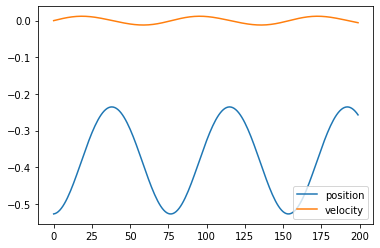

In [20]:
positions, velocities = [], []
observation = env.reset()
while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

# 绘制位置和速度图像
fig, ax = plt.subplots()
ax.plot(positions, label='position')
ax.plot(velocities, label='velocity')
ax.legend()

![result](pics-1-1.png)

从算法来看, 因为 `Sarsa` 是说到做到型, 即on-policy, 在线学习, 学着自己在做的事情. 而 `Q-learning` 是说到但并不一定做到, 所以它也叫作 Off-policy, 离线学习. 

# 使用SARSA算法求解

In [37]:
class TileCoder:
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}
    
    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # 冲突处理
            return hash(codeword) % self.features
        self.codebook[codeword] = count
        return count
    
    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) /
                    self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [38]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=1893, gamma=1.,
                learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n # 动作数
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - \
                env.observation_space.low # 观测空间范围
        self.encoder = TileCoder(layers, features) # 砖瓦编码器
        self.w = np.zeros(features) # 权重
        self.gamma = gamma # 折扣
        self.learning_rate = learning_rate # 学习率
        self.epsilon = epsilon # 探索
        
    def encode(self, observation, action): # 编码
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action): # 动作价值
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation): # 判决
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in
                    range(self.action_n)]
            return np.argmax(qs)
        
    def learn(self, observation, action, reward,
            next_observation, done, next_action): # 学习
        u = reward + (1. - done) * self.gamma * \
                self.get_q(next_observation, next_action)
        td_error = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * td_error)

In [39]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) # 终止状态时此步无意义
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done, next_action)
        if done:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = -10699.0 / 100 = -106.99


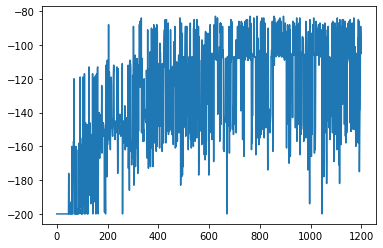

In [40]:
agent = SARSAAgent(env)

# 训练
episodes = 1200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

平均回合奖励 = -106.99
![result](pics-2-2.png)